In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('tweet_disaster/train.csv')
df = df[['text', 'target']]

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Print the first few rows of the training set
train_df.head()

# Print the first few rows of the validation set
val_df.head()


,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0


In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


class DataPreprocessor:
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.length = 0
    
    def preprocess_text(self, text):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Tokenize text
        tokens = word_tokenize(text)
        
        # Remove stopwords
        tokens = [token for token in tokens if token.lower() not in self.stopwords]
        
        # Convert tokens to lowercase
        tokens = [token.lower() for token in tokens]
        
        self.length += len(tokens)

        return tokens
    
    def preprocess_dataframe(self, df):
        df['preprocessed_text'] = df['text'].apply(self.preprocess_text)
        return df

train_df = DataPreprocessor().preprocess_dataframe(train_df)
val_df = DataPreprocessor().preprocess_dataframe(val_df)

print(train_df['preprocessed_text'].iloc[0])
print(len(train_df))
train_df.head()

['courageous', 'honest', 'analysis', 'need', 'use', 'atomic', 'bomb', '1945', 'hiroshima70', 'japanese', 'military', 'refused', 'surrender']
6090


,text,target,preprocessed_text
4996,Courageous and honest analysis of need to use ...,1,"[courageous, honest, analysis, need, use, atom..."
3263,@ZachZaidman @670TheScore wld b a shame if tha...,0,"[zachzaidman, 670thescore, wld, b, shame, golf..."
4907,Tell @BarackObama to rescind medals of 'honor'...,1,"[tell, barackobama, rescind, medals, honor, gi..."
2855,Worried about how the CA drought might affect ...,1,"[worried, ca, drought, might, affect, extreme,..."
4716,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0,"[youngheroesid, lava, blast, amp, power, red, ..."


In [4]:
from gensim.models import Word2Vec

class Word2VecVectorizer:
    def __init__(self, size=100, window=5, min_count=1, workers=4):
        self.word_size = size
        self.sentence_len = 0
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None
    
    def fit(self, data):
        sentences = data.tolist()
        # get the longest tweet
        max_len = 0
        for sentence in sentences:
            if len(sentence) > max_len:
                max_len = len(sentence)
        self.sentence_len = max_len

        self.model = Word2Vec(sentences, window=self.window, min_count=self.min_count, workers=self.workers)
        
    
    def transform(self, data):
        tweets = []
        for word_list in data:
            tweet = []
            count = 0
            
            # get the vector for each word in the tweet
            for word in word_list:
                if word in self.model.wv:
                    vector = self.model.wv[word]
                    # print('word [{}] is in vocab -> vector[{}]'.format(word, vector.shape))
                    tweet.append(vector)
                    count += 1

            # pad the tweet
            if count < self.sentence_len:
                for i in range(self.sentence_len - count):
                    tweet.append(np.zeros(self.word_size))
        
            tweets.append(tweet)
        return np.array(tweets)
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

# Create an instance of the Word2VecVectorizer class
vectorizer = Word2VecVectorizer()

# Fit the vectorizer on the training data
vectorizer.fit(train_df['preprocessed_text'])
# vectorizer.fit(train_df['preprocessed_text'])


# Apply the vectorizer to the training data
train_vectors = vectorizer.transform(train_df['preprocessed_text'])

# Apply the vectorizer to the validation data
val_vectors = vectorizer.transform(val_df['preprocessed_text'])

print(train_vectors.shape, val_vectors.shape)

(6090, 25, 100) (1523, 25, 100)


In [5]:
# Convert the training and validating vectors into PyTorch tensors
train_vectors = torch.FloatTensor(train_vectors)
val_vectors = torch.FloatTensor(val_vectors)

# Convert the targets into PyTorch tensors
train_targets = torch.FloatTensor(train_df['target'].tolist())
val_targets = torch.FloatTensor(val_df['target'].tolist())


In [6]:
# Define the model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.train_losses = []
        self.val_losses = []
        
        # Define the embedding layer
        # self.embedding = nn.Embedding(input_size, hidden_size)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden and cell states
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate the LSTM layer
        out, _ = self.lstm(x, (h0, c0))  
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  
        return out

# Define the hyperparameters
input_size = vectorizer.word_size
hidden_size = 1024
num_layers = 4
num_classes = 1
batch_size = 32
learning_rate = 0.00001
num_epochs = 100
dropout = 0.5

# Create an instance of the model
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout=dropout)


In [7]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Convert the data into PyTorch dataloaders
train_data = torch.utils.data.TensorDataset(train_vectors, train_targets)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

val_data = torch.utils.data.TensorDataset(val_vectors, val_targets)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

# Define the training function
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, clip=5):
    # Initialize the running values for printing training loss and validation loss
    running_loss = 0.0
    val_running_loss = 0.0
    
    model.train_losses = []
    # For each epoch
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        # For each batch in the dataloader
        for i, (tweets, labels) in enumerate(train_loader):
            # Zero out the gradients
            optimizer.zero_grad()
            
            # Get the outputs
            outputs = model(tweets)
            
            # Calculate the loss
            loss = criterion(outputs.squeeze(), labels)
            
            # Backpropagate the loss
            loss.backward()
            
            # Clip the gradients
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
            
            # Update the parameters
            optimizer.step()
            
            # Update the running loss
            running_loss += loss.item()
            
            # Print the epoch, batch, loss
            if (i+1) % 100 == 0:
                print('Epoch: [{}/{}],\t\tStep: [{}/{}],\tLoss: {}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
            
            
        
        # Validate the model
        model.eval()
        
        # For each batch in the dataloader
        for i, (tweets, labels) in enumerate(val_loader):
            # Get the outputs
            outputs = model(tweets)
            
            # Calculate the loss
            loss = criterion(outputs.squeeze(), labels)

            # calculate accuracy
            pred = torch.round(torch.sigmoid(outputs.squeeze()))
            correct_tensor = pred.eq(labels.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy())
            # calculate test accuracy for each object class
            # for i in range(len(labels)):
            #     label = labels[i]
            #     class_correct[label] += correct[i].item()

            
            # Update the running loss
            val_running_loss += loss.item()
        
        # Print the epoch, training loss, validation loss
        print('Epoch: [{}/{}],\t\tTraining Loss: {},\tValidation Loss: {},\tAccuracy: {}'.format(
            epoch+1, num_epochs, running_loss/len(train_loader), val_running_loss/len(val_loader), np.mean(correct)))
        
        # Append the training loss and validation loss
        model.train_losses.append(running_loss/len(train_loader))
        model.val_losses.append(val_running_loss/len(val_loader))
        
        # Reset the running loss
        running_loss = 0.0
        val_running_loss = 0.0

# Train the model
train(model, criterion, optimizer, train_loader, val_loader, num_epochs, device='cpu')




Epoch: [1/100],	Step: [100/191],	Loss: 0.686129629611969
Epoch: [1/100],	Training Loss: 0.6862216582473036,	Validation Loss: 0.6826438109079996,	Accuracy: 0.5263157894736842
Epoch: [2/100],	Step: [100/191],	Loss: 0.6852307319641113
Epoch: [2/100],	Training Loss: 0.683748603803325,	Validation Loss: 0.6825384261707464,	Accuracy: 0.5263157894736842
Epoch: [3/100],	Step: [100/191],	Loss: 0.6853609681129456
Epoch: [3/100],	Training Loss: 0.6837312682136816,	Validation Loss: 0.6825161625941595,	Accuracy: 0.5263157894736842
Epoch: [4/100],	Step: [100/191],	Loss: 0.6847246289253235
Epoch: [4/100],	Training Loss: 0.6836768160939841,	Validation Loss: 0.6824958361685276,	Accuracy: 0.5263157894736842
Epoch: [5/100],	Step: [100/191],	Loss: 0.6854602694511414
Epoch: [5/100],	Training Loss: 0.6836662342411062,	Validation Loss: 0.6824833502372106,	Accuracy: 0.5263157894736842
Epoch: [6/100],	Step: [100/191],	Loss: 0.6852905750274658
Epoch: [6/100],	Training Loss: 0.6836483987214054,	Validation Loss: 0

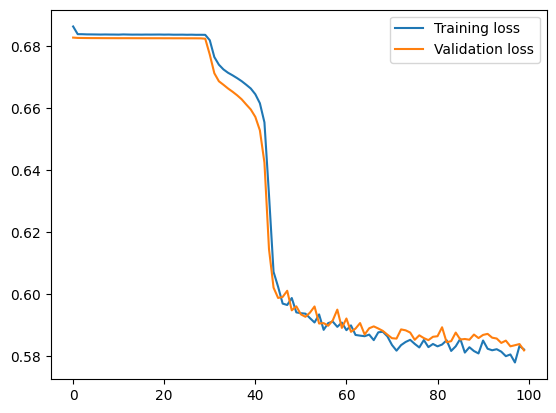

In [9]:
# Plot the training and validation losses
plt.plot(model.train_losses, label='Training loss')
plt.plot(model.val_losses, label='Validation loss')
plt.legend()
plt.show()

In [10]:
# precision on validation set
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def evaluate(model, val_loader):
    y_true = []
    y_pred = []
    model.eval()
    for i, (tweets, labels) in enumerate(val_loader):
        outputs = model(tweets)
        y_pred.extend(torch.round(torch.sigmoid(outputs.squeeze())).tolist())
        y_true.extend(labels.tolist())
    print('precision: {}'.format(precision_score(y_true, y_pred, zero_division=1)))
    print('recall: {}'.format(recall_score(y_true, y_pred)))
    print('f1: {}'.format(f1_score(y_true, y_pred)))
    print('confusion matrix: {}'.format(confusion_matrix(y_true, y_pred)))

evaluate(model, train_loader)
evaluate(model, val_loader)

precision: 0.7350917431192661
recall: 0.4889397406559878
f1: 0.587265231333028
confusion matrix: [[3006  462]
 [1340 1282]]
precision: 0.7420212765957447
recall: 0.42989214175654855
f1: 0.5443902439024391
confusion matrix: [[777  97]
 [370 279]]


In [11]:
# Define the test data
test_df = pd.read_csv('tweet_disaster/test.csv')
test_df = test_df[['text']]
test_df = DataPreprocessor().preprocess_dataframe(test_df)
test_vectors = vectorizer.transform(test_df['preprocessed_text'])
test_vectors = torch.FloatTensor(test_vectors)

# Make predictions on the test data and calculate F1 score
model.eval()
with torch.no_grad():
    predictions = model(test_vectors)
    predictions = predictions.squeeze()
    predictions = torch.round(torch.sigmoid(predictions))
    print(predictions)
    print(predictions.shape)
    print(predictions.tolist())

# Save the predictions to a CSV file
submission_df = pd.read_csv('tweet_disaster/sample_submission.csv')
submission_df['target'] = predictions.tolist()
submission_df['target'] = submission_df['target'].astype(int)
submission_df.to_csv('tweet_disaster/submission.csv', index=False)





tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([3263])
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0